<a href="https://colab.research.google.com/github/tumanov-a/imdb_sentiment_analys/blob/main/IMDB_pytorch_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [10]:
train = pd.read_csv('prep_train.csv')
val = pd.read_csv('prep_val.csv')

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
def replace_(fragment):
  fragment = re.sub('<br />', '', fragment)
  return fragment

In [13]:
train['text'] = train['text'].apply(lambda x: x[:512])
train['class'] = train['class'].map({'M': 1, 'H': 0})

In [14]:
val['text'] = val['text'].apply(lambda x: x[:512])
val['class'] = val['class'].map({'M': 1, 'H': 0})

In [15]:
train['text'] = train['text'].apply(lambda x: '[CLS] ' + x + ' [SEP]')

In [16]:
val['text'] = val['text'].apply(lambda x: '[CLS] ' + x + ' [SEP]')

In [44]:
train['text']

0         [CLS] Обустройство тротуаров, мостовых (в том ...
1         [CLS] Въ издержкахъ же оныхъ вы имете присылат...
2                 [CLS] Положи это туда, откуда взял. [SEP]
3         [CLS] Минстрой обозначил способы снижения энер...
4         [CLS] В конце 1873 года военный суд вынес реше...
                                ...                        
129061    [CLS] Убытки МУП &quot;Теплоэнерго&nbsp;&ndash...
129062    [CLS] Три сестры были молодёжными послами на Н...
129063    [CLS] В Прекрасной России Будущего коты создад...
129064                    [CLS] В семье наше будущее! [SEP]
129065    [CLS] Минюст рассказал об ответственности за п...
Name: text, Length: 129066, dtype: object

In [17]:
list(train)

['id',
 'text',
 'class',
 'lemm_text',
 'len_text_text',
 'count_punct_text',
 'count_numbers_text',
 'count_digits_text',
 'count_uppercase_text',
 'count_lowercase_text',
 'avg_word_len_text',
 'mean_ru_vowel_occurance_text',
 'mean_ru_consonant_occurance_text',
 'mean_en_vowel_occurance_text',
 'mean_en_consonant_occurance_text',
 'count_space_text',
 'count_kirr_text',
 'count_lat_text',
 'POS_text',
 'count_POS_text',
 'sent_POS_text',
 'POS_NOUN_text',
 'POS_ADJF_text',
 'POS_PREP_text',
 'POS_None_text',
 'POS_PRCL_text',
 'POS_NPRO_text',
 'POS_INFN_text',
 'POS_ADVB_text',
 'POS_CONJ_text',
 'POS_VERB_text',
 'POS_PRED_text',
 'POS_ADJS_text',
 'POS_PRTF_text',
 'POS_PRTS_text',
 'POS_INTJ_text',
 'POS_NUMR_text',
 'POS_GRND_text',
 'POS_COMP_text']

In [18]:
cols = [col for col in list(train) if 'ft_' not in col]

dropped_cols = ['count_POS_text', 'POS_text', 'id', 'class', 'lemm_text']

for col in dropped_cols:
    cols.pop(cols.index(col))

In [19]:
train.fillna(0, inplace=True)

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
scaler = StandardScaler()

In [22]:
x_train, y_train = train[cols], train['class']
x_val, y_val = val[cols], val['class']

In [23]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
from tqdm import tqdm

tokenized_texts = [tokenizer.tokenize(sent) for sent in tqdm(x_train['text'])]

100%|█████████████████████████████████████████████████████████████████████████| 129066/129066 [00:30<00:00, 4214.84it/s]


In [25]:
val_tokenized_texts = [tokenizer.tokenize(sent) for sent in tqdm(x_val['text'])]

100%|███████████████████████████████████████████████████████████████████████████| 21511/21511 [00:05<00:00, 4204.25it/s]


In [26]:
feature_cols = [col for col in list(x_train)]
feature_cols = feature_cols[1:][:14] + feature_cols[1:][15:]

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_inputs = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_texts)]

train_inputs = pad_sequences(train_inputs, 
                          dtype='long', 
                          padding='post', 
                          truncating='post')

train_masks = [[float(i>0) for i in seq] for seq in train_inputs]

validation_inputs = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(val_tokenized_texts)]

validation_inputs = pad_sequences(validation_inputs, 
                          dtype='long', 
                          padding='post', 
                          truncating='post')



validation_masks = [[float(i>0) for i in seq] for seq in validation_inputs]

train_labels, validation_labels = np.array(y_train), np.array(y_val)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

train_features = np.array(train[feature_cols], dtype='float32')
validation_features = np.array(val[feature_cols], dtype='float32')
train_features = scaler.fit_transform(train_features)
validation_features = scaler.transform(validation_features)

train_features = torch.tensor(train_features)
validation_features = torch.tensor(validation_features)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

train_data = torch.utils.data.TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=4,
    sampler=torch.utils.data.RandomSampler(train_data)
)

validation_data = torch.utils.data.TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = torch.utils.data.DataLoader(
    validation_data,
    batch_size=4,
    sampler=torch.utils.data.SequentialSampler(validation_data)
)

100%|██████████████████████████████████████████████████████████████████████████| 21511/21511 [00:00<00:00, 39661.79it/s]


In [20]:
train_masks

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

In [30]:
from transformers import AdamW, AutoConfig

In [39]:

class myBertModel(torch.nn.Module):
    def __init__(self, hidden_neurons):
        super(myBertModel, self).__init__()
        config = AutoConfig.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=2)
        self.model = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased', config=config)
        self.hidden_neurons = hidden_neurons
        #self.n_features = n_features
        self.linear_1 = torch.nn.Linear(config.hidden_size, self.hidden_neurons)
        self.linear_2 = torch.nn.Linear(self.hidden_neurons, int(self.hidden_neurons / 2))
        #self.linear_3 = torch.nn.Linear(self.n_features, int(self.n_features / 2))
        #self.linear_4 = torch.nn.Linear(int(self.n_features / 2), int(self.hidden_neurons / 2))
        self.classifier = torch.nn.Linear(int(self.hidden_neurons / 2), 2)
        self.activation = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(.1)

    def forward(self, input_ids, attention_mask):
        bert_output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        seq_output = bert_output[0]
        pooled_output = seq_output.mean(axis=1)
        pooled_output = self.dropout(pooled_output)
        linear_output = self.linear_1(pooled_output)
        linear_output_2 = self.linear_2(linear_output)
        #linear_output_3 = self.linear_3(features)
        #linear_output_3 = self.dropout(linear_output_3)
        #linear_output_4 = self.linear_4(linear_output_3)
        #scores = self.classifier(torch.cat([linear_output_2, linear_output_4], dim=1))
        scores = self.classifier(linear_output_2)
        scores = self.dropout(scores)
        scores = self.activation(scores)
        return scores

# my_model = myBertModel(hidden_neurons=512, n_features=len(feature_cols))
my_model = myBertModel(hidden_neurons=512)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
super_model = torch.nn.DataParallel(my_model, device_ids=[0,1,2,3,4,5,6,7,8,9,10,11,12,13])

In [40]:
optimizer = AdamW(my_model.parameters(), lr=5e-5)
loss = torch.nn.CrossEntropyLoss()

In [41]:
my_model.to(device)
my_model.train()

myBertModel(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [35]:
from tqdm import tqdm

In [119]:
for batch in tqdm(train_dataloader):
    batch = tuple(t.to('cpu') for t in batch)
    b_input_ids, b_input_mask, b_features, b_labels = batch
    break

  0%|                                                                                          | 0/8067 [00:00<?, ?it/s]


In [42]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

In [43]:
loss_set = []
val_loss_set = []
my_model.train()
n_epochs = 3

for epoch in tqdm(range(n_epochs)):
    for i, batch in tqdm(enumerate(train_dataloader)):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        pred_labels = my_model.forward(b_input_ids, b_input_mask)
        my_loss = loss(pred_labels, b_labels)
        loss_set.append(my_loss.item())
        my_loss.backward()
        optimizer.step()
        
        if i % 10000 == 0 and i != 0:
            test_probs = []
            test_labels = []
            test_preds = []
            for batch in validation_dataloader:
                batch = tuple(t.to(device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch

                with torch.no_grad():
                    pred_labels = my_model.forward(b_input_ids, b_input_mask)
                    val_loss = loss(pred_labels, b_labels)
                    val_loss_set.append(val_loss.item())

                b_labels = b_labels.to('cpu').numpy()
                pred_labels = pred_labels.to('cpu').numpy()

                test_probs.extend(pred_labels)
                pred_labels = pred_labels.argmax(axis=1)

                test_labels.extend(b_labels)
                test_preds.extend(pred_labels)

            test_acc = accuracy_score(test_labels, test_preds)
            test_precision = precision_score(test_labels, test_preds)
            test_recall = recall_score(test_labels, test_preds)
            test_f1 = f1_score(test_labels, test_preds)

            print('Val accuracy: {:.2f} ... Val precision: {:.2f} ... Val recall: {:.2f} ... Val f1: {:.2f}'.format(test_acc, test_precision, test_recall, test_f1))

  0%|                                                                                             | 0/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  7.98it/s]
2it [00:00,  8.24it/s]
4it [00:00, 10.16it/s]
6it [00:00, 10.98it/s]
8it [00:00, 11.41it/s]
10it [00:00, 11.66it/s]
12it [00:01, 11.82it/s]
14it [00:01, 11.92it/s]
16it [00:01, 12.00it/s]
18it [00:01, 12.05it/s]
20it [00:01, 12.04it/s]
22it [00:01, 11.95it/s]
24it [00:02, 12.01it/s]
26it [00:02, 11.68it/s]
28it [00:02, 11.81it/s]
30it [00:02, 11.89it/s]
32it [00:02, 11.98it/s]
34it [00:02, 12.04it/s]
36it [00:03, 12.07it/s]
38it [00:03, 12.03it/s]
40it [00:03, 12.07it/s]
42it [00:03, 12.08it/s]
44it [00:03, 11.72it/s]
46it [00:03, 11.85it/s]
48it [00:04, 11.92it/s]
50it [00:04, 11.99it/s]
52it [00:04, 12.04it/s]
54it [00:04, 12.07it/s]
56it [00:04, 12.01it/s]
58it [00:04, 12.05it/s]
60it [00:05, 12.07it/s]
62it [00:05, 12.07it/s]
64it [00:05, 12.10it/s]
66it [00:05, 12.10it/s]
68it [00:05, 12.12it/s]
70it [00:05, 12.13it/s]
7

1156it [01:35, 12.11it/s]
1158it [01:36, 12.12it/s]
1160it [01:36, 12.08it/s]
1162it [01:36, 12.06it/s]
1164it [01:36, 12.07it/s]
1166it [01:36, 12.08it/s]
1168it [01:36, 12.10it/s]
1170it [01:37, 12.11it/s]
1172it [01:37, 12.10it/s]
1174it [01:37, 12.12it/s]
1176it [01:37, 12.12it/s]
1178it [01:37, 12.08it/s]
1180it [01:37, 11.97it/s]
1182it [01:38, 12.02it/s]
1184it [01:38, 12.04it/s]
1186it [01:38, 12.08it/s]
1188it [01:38, 12.10it/s]
1190it [01:38, 12.12it/s]
1192it [01:38, 12.12it/s]
1194it [01:39, 12.08it/s]
1196it [01:39, 12.10it/s]
1198it [01:39, 12.11it/s]
1200it [01:39, 12.09it/s]
1202it [01:39, 12.11it/s]
1204it [01:39, 12.12it/s]
1206it [01:40, 12.11it/s]
1208it [01:40, 12.12it/s]
1210it [01:40, 12.12it/s]
1212it [01:40, 12.07it/s]
1214it [01:40, 12.10it/s]
1216it [01:40, 12.10it/s]
1218it [01:41, 12.10it/s]
1220it [01:41, 12.12it/s]
1222it [01:41, 12.12it/s]
1224it [01:41, 12.13it/s]
1226it [01:41, 12.13it/s]
1228it [01:41, 12.14it/s]
1230it [01:42, 12.12it/s]
1232it [01:4

2284it [03:09, 11.94it/s]
2286it [03:09, 11.99it/s]
2288it [03:09, 12.03it/s]
2290it [03:10, 12.06it/s]
2292it [03:10, 12.00it/s]
2294it [03:10, 11.99it/s]
2296it [03:10, 11.91it/s]
2298it [03:10, 11.69it/s]
2300it [03:11, 11.82it/s]
2302it [03:11, 11.90it/s]
2304it [03:11, 11.95it/s]
2306it [03:11, 12.00it/s]
2308it [03:11, 11.97it/s]
2310it [03:11, 12.02it/s]
2312it [03:11, 12.04it/s]
2314it [03:12, 11.67it/s]
2316it [03:12, 11.81it/s]
2318it [03:12, 11.89it/s]
2320it [03:12, 11.95it/s]
2322it [03:12, 12.01it/s]
2324it [03:13, 12.04it/s]
2326it [03:13, 12.02it/s]
2328it [03:13, 12.05it/s]
2330it [03:13, 12.01it/s]
2332it [03:13, 12.04it/s]
2334it [03:13, 12.07it/s]
2336it [03:14, 12.08it/s]
2338it [03:14, 12.10it/s]
2340it [03:14, 12.10it/s]
2342it [03:14, 12.11it/s]
2344it [03:14, 12.01it/s]
2346it [03:14, 12.00it/s]
2348it [03:15, 11.97it/s]
2350it [03:15, 11.93it/s]
2352it [03:15, 11.98it/s]
2354it [03:15, 12.02it/s]
2356it [03:15, 12.05it/s]
2358it [03:15, 12.08it/s]
2360it [03:1

3412it [04:43, 12.01it/s]
3414it [04:43, 11.97it/s]
3416it [04:43, 12.03it/s]
3418it [04:43, 12.04it/s]
3420it [04:44, 12.07it/s]
3422it [04:44, 12.09it/s]
3424it [04:44, 12.11it/s]
3426it [04:44, 12.06it/s]
3428it [04:44, 12.08it/s]
3430it [04:44, 12.04it/s]
3432it [04:45, 12.06it/s]
3434it [04:45, 12.08it/s]
3436it [04:45, 12.10it/s]
3438it [04:45, 12.11it/s]
3440it [04:45, 12.12it/s]
3442it [04:45, 12.09it/s]
3444it [04:46, 12.07it/s]
3446it [04:46, 12.08it/s]
3448it [04:46, 12.03it/s]
3450it [04:46, 12.07it/s]
3452it [04:46, 12.09it/s]
3454it [04:46, 12.09it/s]
3456it [04:47, 12.11it/s]
3458it [04:47, 12.12it/s]
3460it [04:47, 12.07it/s]
3462it [04:47, 12.06it/s]
3464it [04:47, 12.08it/s]
3466it [04:47, 11.31it/s]
3468it [04:48, 11.54it/s]
3470it [04:48, 11.71it/s]
3472it [04:48, 11.83it/s]
3474it [04:48, 11.92it/s]
3476it [04:48, 11.98it/s]
3478it [04:48, 11.98it/s]
3480it [04:49, 12.02it/s]
3482it [04:49, 12.04it/s]
3484it [04:49, 11.98it/s]
3486it [04:49, 12.03it/s]
3488it [04:4

4540it [06:17, 12.03it/s]
4542it [06:17, 12.05it/s]
4544it [06:17, 12.07it/s]
4546it [06:17, 12.04it/s]
4548it [06:17, 12.06it/s]
4550it [06:17, 12.05it/s]
4552it [06:18, 12.07it/s]
4554it [06:18, 12.09it/s]
4556it [06:18, 12.11it/s]
4558it [06:18, 11.95it/s]
4560it [06:18, 12.01it/s]
4562it [06:18, 12.04it/s]
4564it [06:19, 12.07it/s]
4566it [06:19, 12.08it/s]
4568it [06:19, 12.10it/s]
4570it [06:19, 12.12it/s]
4572it [06:19, 12.12it/s]
4574it [06:19, 12.08it/s]
4576it [06:20, 12.08it/s]
4578it [06:20, 12.09it/s]
4580it [06:20, 11.96it/s]
4582it [06:20, 12.08it/s]
4584it [06:20, 12.08it/s]
4586it [06:20, 12.09it/s]
4588it [06:21, 12.11it/s]
4590it [06:21, 12.11it/s]
4592it [06:21, 12.07it/s]
4594it [06:21, 12.09it/s]
4596it [06:21, 12.10it/s]
4598it [06:21, 12.05it/s]
4600it [06:22, 12.08it/s]
4602it [06:22, 12.08it/s]
4604it [06:22, 12.09it/s]
4606it [06:22, 12.08it/s]
4608it [06:22, 12.09it/s]
4610it [06:22, 12.06it/s]
4612it [06:23, 12.07it/s]
4614it [06:23, 12.07it/s]
4616it [06:2

5668it [07:50, 12.12it/s]
5670it [07:50, 12.13it/s]
5672it [07:51, 12.01it/s]
5674it [07:51, 12.03it/s]
5676it [07:51, 11.76it/s]
5678it [07:51, 11.89it/s]
5680it [07:51, 11.96it/s]
5682it [07:51, 12.00it/s]
5684it [07:52, 12.03it/s]
5686it [07:52, 12.06it/s]
5688it [07:52, 12.04it/s]
5690it [07:52, 12.07it/s]
5692it [07:52, 12.10it/s]
5694it [07:52, 12.10it/s]
5696it [07:53, 12.11it/s]
5698it [07:53, 12.13it/s]
5700it [07:53, 12.13it/s]
5702it [07:53, 12.13it/s]
5704it [07:53, 12.14it/s]
5706it [07:53, 12.09it/s]
5708it [07:54, 12.10it/s]
5710it [07:54, 12.07it/s]
5712it [07:54, 12.03it/s]
5714it [07:54, 12.05it/s]
5716it [07:54, 12.06it/s]
5718it [07:54, 12.09it/s]
5720it [07:55, 12.10it/s]
5722it [07:55, 12.08it/s]
5724it [07:55, 12.08it/s]
5726it [07:55, 12.09it/s]
5728it [07:55, 12.04it/s]
5730it [07:55, 12.06it/s]
5732it [07:56, 12.08it/s]
5734it [07:56, 12.09it/s]
5736it [07:56, 12.09it/s]
5738it [07:56, 12.10it/s]
5740it [07:56, 12.06it/s]
5742it [07:56, 12.06it/s]
5744it [07:5

6796it [09:24, 12.06it/s]
6798it [09:24, 12.07it/s]
6800it [09:24, 12.04it/s]
6802it [09:24, 12.05it/s]
6804it [09:25, 12.07it/s]
6806it [09:25, 12.03it/s]
6808it [09:25, 12.06it/s]
6810it [09:25, 12.07it/s]
6812it [09:25, 12.09it/s]
6814it [09:25, 12.10it/s]
6816it [09:26, 12.11it/s]
6818it [09:26, 12.11it/s]
6820it [09:26, 12.11it/s]
6822it [09:26, 12.06it/s]
6824it [09:26, 12.12it/s]
6826it [09:26, 12.12it/s]
6828it [09:27, 12.11it/s]
6830it [09:27, 12.12it/s]
6832it [09:27, 12.12it/s]
6834it [09:27, 12.10it/s]
6836it [09:27, 12.11it/s]
6838it [09:27, 12.11it/s]
6840it [09:28, 12.05it/s]
6842it [09:28, 12.11it/s]
6844it [09:28, 12.11it/s]
6846it [09:28, 12.10it/s]
6848it [09:28, 12.10it/s]
6850it [09:28, 12.11it/s]
6852it [09:29, 12.06it/s]
6854it [09:29, 12.09it/s]
6856it [09:29, 12.09it/s]
6858it [09:29, 12.03it/s]
6860it [09:29, 12.08it/s]
6862it [09:29, 12.08it/s]
6864it [09:30, 12.07it/s]
6866it [09:30, 12.08it/s]
6868it [09:30, 12.11it/s]
6870it [09:30, 12.08it/s]
6872it [09:3

7924it [10:58, 12.06it/s]
7926it [10:58, 12.07it/s]
7928it [10:58, 12.08it/s]
7930it [10:58, 12.09it/s]
7932it [10:58, 12.09it/s]
7934it [10:58, 12.10it/s]
7936it [10:59, 12.09it/s]
7938it [10:59, 12.09it/s]
7940it [10:59, 12.05it/s]
7942it [10:59, 12.04it/s]
7944it [10:59, 12.03it/s]
7946it [10:59, 12.10it/s]
7948it [11:00, 12.10it/s]
7950it [11:00, 12.11it/s]
7952it [11:00, 12.11it/s]
7954it [11:00, 12.06it/s]
7956it [11:00, 12.08it/s]
7958it [11:00, 12.04it/s]
7960it [11:01, 12.06it/s]
7962it [11:01, 12.06it/s]
7964it [11:01, 12.07it/s]
7966it [11:01, 12.08it/s]
7968it [11:01, 12.10it/s]
7970it [11:01, 12.11it/s]
7972it [11:02, 12.08it/s]
7974it [11:02, 12.08it/s]
7976it [11:02, 12.09it/s]
7978it [11:02, 12.10it/s]
7980it [11:02, 12.11it/s]
7982it [11:02, 12.11it/s]
7984it [11:03, 12.12it/s]
7986it [11:03, 12.14it/s]
7988it [11:03, 12.13it/s]
7990it [11:03, 11.92it/s]
7992it [11:03, 11.94it/s]
7994it [11:03, 11.93it/s]
7996it [11:04, 11.96it/s]
7998it [11:04, 12.00it/s]
8000it [11:0

9052it [12:31, 12.00it/s]
9054it [12:31, 12.04it/s]
9056it [12:32, 12.05it/s]
9058it [12:32, 12.05it/s]
9060it [12:32, 12.07it/s]
9062it [12:32, 12.08it/s]
9064it [12:32, 11.98it/s]
9066it [12:32, 11.81it/s]
9068it [12:33, 11.90it/s]
9070it [12:33, 11.95it/s]
9072it [12:33, 12.00it/s]
9074it [12:33, 12.02it/s]
9076it [12:33, 12.06it/s]
9078it [12:33, 12.08it/s]
9080it [12:34, 12.09it/s]
9082it [12:34, 11.67it/s]
9084it [12:34, 11.85it/s]
9086it [12:34, 11.90it/s]
9088it [12:34, 11.98it/s]
9090it [12:34, 12.02it/s]
9092it [12:35, 12.00it/s]
9094it [12:35, 11.96it/s]
9096it [12:35, 12.01it/s]
9098it [12:35, 12.05it/s]
9100it [12:35, 12.03it/s]
9102it [12:35, 12.00it/s]
9104it [12:36, 11.97it/s]
9106it [12:36, 11.79it/s]
9108it [12:36, 11.89it/s]
9110it [12:36, 11.95it/s]
9112it [12:36, 12.01it/s]
9114it [12:36, 12.05it/s]
9116it [12:37, 12.05it/s]
9118it [12:37, 12.04it/s]
9120it [12:37, 12.05it/s]
9122it [12:37, 12.02it/s]
9124it [12:37, 12.01it/s]
9126it [12:37, 12.04it/s]
9128it [12:3

Val accuracy: 0.50 ... Val precision: 0.51 ... Val recall: 0.09 ... Val f1: 0.16



10005it [15:41,  8.85s/it]
10007it [15:41,  6.08s/it]
10009it [15:41,  4.21s/it]
10011it [15:41,  2.94s/it]
10013it [15:42,  2.07s/it]
10015it [15:42,  1.47s/it]
10017it [15:42,  1.05s/it]
10019it [15:42,  1.32it/s]
10021it [15:42,  1.81it/s]
10023it [15:42,  2.43it/s]
10025it [15:43,  3.20it/s]
10027it [15:43,  4.10it/s]
10029it [15:43,  5.05it/s]
10031it [15:43,  6.11it/s]
10033it [15:43,  7.18it/s]
10035it [15:43,  8.18it/s]
10037it [15:44,  9.07it/s]
10039it [15:44,  9.78it/s]
10041it [15:44, 10.20it/s]
10043it [15:44, 10.72it/s]
10045it [15:44, 11.10it/s]
10047it [15:44, 11.40it/s]
10049it [15:45, 11.61it/s]
10051it [15:45, 11.77it/s]
10053it [15:45, 11.86it/s]
10055it [15:45, 11.95it/s]
10057it [15:45, 12.00it/s]
10059it [15:45, 12.04it/s]
10061it [15:46, 12.07it/s]
10063it [15:46, 12.08it/s]
10065it [15:46, 12.09it/s]
10067it [15:46, 12.10it/s]
10069it [15:46, 12.11it/s]
10071it [15:46, 12.11it/s]
10073it [15:47, 12.07it/s]
10075it [15:47, 12.09it/s]
10077it [15:47, 12.08it/s]


11097it [17:11, 12.14it/s]
11099it [17:11, 12.14it/s]
11101it [17:12, 12.14it/s]
11103it [17:12, 12.14it/s]
11105it [17:12, 12.09it/s]
11107it [17:12, 12.08it/s]
11109it [17:12, 12.07it/s]
11111it [17:12, 12.07it/s]
11113it [17:13, 12.06it/s]
11115it [17:13, 12.04it/s]
11117it [17:13, 12.04it/s]
11119it [17:13, 12.03it/s]
11121it [17:13, 12.03it/s]
11123it [17:13, 12.02it/s]
11125it [17:14, 12.01it/s]
11127it [17:14, 12.02it/s]
11129it [17:14, 12.02it/s]
11131it [17:14, 12.03it/s]
11133it [17:14, 12.03it/s]
11135it [17:14, 12.03it/s]
11137it [17:15, 12.03it/s]
11139it [17:15, 12.03it/s]
11141it [17:15, 12.04it/s]
11143it [17:15, 12.05it/s]
11145it [17:15, 12.03it/s]
11147it [17:15, 12.01it/s]
11149it [17:16, 12.01it/s]
11151it [17:16, 12.03it/s]
11153it [17:16, 12.03it/s]
11155it [17:16, 12.10it/s]
11157it [17:16, 12.11it/s]
11159it [17:16, 12.11it/s]
11161it [17:17, 12.12it/s]
11163it [17:17, 12.12it/s]
11165it [17:17, 12.10it/s]
11167it [17:17, 12.11it/s]
11169it [17:17, 12.12it/s]
1

12189it [18:42, 12.10it/s]
12191it [18:42, 12.05it/s]
12193it [18:42, 12.06it/s]
12195it [18:42, 12.07it/s]
12197it [18:42, 12.05it/s]
12199it [18:43, 12.05it/s]
12201it [18:43, 12.07it/s]
12203it [18:43, 12.09it/s]
12205it [18:43, 12.10it/s]
12207it [18:43, 12.07it/s]
12209it [18:43, 12.08it/s]
12211it [18:44, 12.09it/s]
12213it [18:44, 12.08it/s]
12215it [18:44, 12.09it/s]
12217it [18:44, 12.09it/s]
12219it [18:44, 12.11it/s]
12221it [18:44, 12.12it/s]
12223it [18:45, 12.12it/s]
12225it [18:45, 11.99it/s]
12227it [18:45, 12.09it/s]
12229it [18:45, 12.09it/s]
12231it [18:45, 12.02it/s]
12233it [18:45, 12.06it/s]
12235it [18:46, 12.08it/s]
12237it [18:46, 12.09it/s]
12239it [18:46, 12.10it/s]
12241it [18:46, 12.10it/s]
12243it [18:46, 11.72it/s]
12245it [18:46, 11.84it/s]
12247it [18:47, 11.88it/s]
12249it [18:47, 11.93it/s]
12251it [18:47, 11.99it/s]
12253it [18:47, 12.02it/s]
12255it [18:47, 12.06it/s]
12257it [18:47, 12.08it/s]
12259it [18:48, 12.09it/s]
12261it [18:48, 11.68it/s]
1

13281it [20:12, 12.07it/s]
13283it [20:13, 12.07it/s]
13285it [20:13, 12.09it/s]
13287it [20:13, 12.10it/s]
13289it [20:13, 12.12it/s]
13291it [20:13, 12.06it/s]
13293it [20:13, 12.09it/s]
13295it [20:14, 12.09it/s]
13297it [20:14, 12.06it/s]
13299it [20:14, 12.08it/s]
13301it [20:14, 12.08it/s]
13303it [20:14, 12.08it/s]
13305it [20:14, 12.09it/s]
13307it [20:14, 12.10it/s]
13309it [20:15, 12.08it/s]
13311it [20:15, 12.08it/s]
13313it [20:15, 12.09it/s]
13315it [20:15, 12.06it/s]
13317it [20:15, 12.08it/s]
13319it [20:15, 12.08it/s]
13321it [20:16, 12.10it/s]
13323it [20:16, 12.11it/s]
13325it [20:16, 12.12it/s]
13327it [20:16, 12.08it/s]
13329it [20:16, 12.08it/s]
13331it [20:16, 12.04it/s]
13333it [20:17, 12.06it/s]
13335it [20:17, 12.07it/s]
13337it [20:17, 12.08it/s]
13339it [20:17, 12.10it/s]
13341it [20:17, 12.10it/s]
13343it [20:17, 12.11it/s]
13345it [20:18, 12.09it/s]
13347it [20:18, 12.09it/s]
13349it [20:18, 12.08it/s]
13351it [20:18, 12.08it/s]
13353it [20:18, 12.07it/s]
1

14373it [21:43, 12.06it/s]
14375it [21:43, 12.07it/s]
14377it [21:43, 12.08it/s]
14379it [21:44, 12.04it/s]
14381it [21:44, 12.06it/s]
14383it [21:44, 12.07it/s]
14385it [21:44, 12.09it/s]
14387it [21:44, 12.10it/s]
14389it [21:44, 12.11it/s]
14391it [21:45, 12.11it/s]
14393it [21:45, 12.10it/s]
14395it [21:45, 12.06it/s]
14397it [21:45, 12.06it/s]
14399it [21:45, 12.07it/s]
14401it [21:45, 12.08it/s]
14403it [21:45, 12.10it/s]
14405it [21:46, 12.10it/s]
14407it [21:46, 12.11it/s]
14409it [21:46, 11.85it/s]
14411it [21:46, 11.92it/s]
14413it [21:46, 11.91it/s]
14415it [21:47, 11.96it/s]
14417it [21:47, 12.00it/s]
14419it [21:47, 12.04it/s]
14421it [21:47, 12.06it/s]
14423it [21:47, 12.08it/s]
14425it [21:47, 12.05it/s]
14427it [21:47, 12.06it/s]
14429it [21:48, 12.06it/s]
14431it [21:48, 11.68it/s]
14433it [21:48, 11.81it/s]
14435it [21:48, 11.89it/s]
14437it [21:48, 11.95it/s]
14439it [21:49, 12.00it/s]
14441it [21:49, 12.04it/s]
14443it [21:49, 12.01it/s]
14445it [21:49, 12.03it/s]
1

15465it [23:14, 12.12it/s]
15467it [23:14, 12.06it/s]
15469it [23:14, 12.12it/s]
15471it [23:14, 12.10it/s]
15473it [23:14, 11.98it/s]
15475it [23:14, 11.96it/s]
15477it [23:15, 12.01it/s]
15479it [23:15, 12.01it/s]
15481it [23:15, 12.04it/s]
15483it [23:15, 11.99it/s]
15485it [23:15, 11.96it/s]
15487it [23:15, 11.99it/s]
15489it [23:16, 12.02it/s]
15491it [23:16, 11.99it/s]
15493it [23:16, 12.02it/s]
15495it [23:16, 12.04it/s]
15497it [23:16, 12.07it/s]
15499it [23:16, 12.09it/s]
15501it [23:17, 12.10it/s]
15503it [23:17, 12.06it/s]
15505it [23:17, 12.04it/s]
15507it [23:17, 12.05it/s]
15509it [23:17, 12.00it/s]
15511it [23:17, 12.04it/s]
15513it [23:18, 12.05it/s]
15515it [23:18, 12.07it/s]
15517it [23:18, 12.10it/s]
15519it [23:18, 12.12it/s]
15521it [23:18, 12.11it/s]
15523it [23:18, 12.08it/s]
15525it [23:19, 12.09it/s]
15527it [23:19, 12.02it/s]
15529it [23:19, 12.05it/s]
15531it [23:19, 12.06it/s]
15533it [23:19, 12.07it/s]
15535it [23:19, 12.10it/s]
15537it [23:20, 12.12it/s]
1

16557it [24:44, 12.05it/s]
16559it [24:44, 12.08it/s]
16561it [24:45, 12.09it/s]
16563it [24:45, 12.10it/s]
16565it [24:45, 12.07it/s]
16567it [24:45, 12.08it/s]
16569it [24:45, 12.05it/s]
16571it [24:45, 12.03it/s]
16573it [24:46, 12.08it/s]
16575it [24:46, 12.08it/s]
16577it [24:46, 12.09it/s]
16579it [24:46, 12.11it/s]
16581it [24:46, 12.04it/s]
16583it [24:46, 12.03it/s]
16585it [24:47, 12.05it/s]
16587it [24:47, 12.02it/s]
16589it [24:47, 12.05it/s]
16591it [24:47, 12.06it/s]
16593it [24:47, 12.08it/s]
16595it [24:47, 12.10it/s]
16597it [24:48, 12.10it/s]
16599it [24:48, 12.06it/s]
16601it [24:48, 12.11it/s]
16603it [24:48, 12.07it/s]
16605it [24:48, 11.66it/s]
16607it [24:48, 11.77it/s]
16609it [24:49, 11.86it/s]
16611it [24:49, 11.94it/s]
16613it [24:49, 11.99it/s]
16615it [24:49, 12.04it/s]
16617it [24:49, 12.01it/s]
16619it [24:49, 12.04it/s]
16621it [24:50, 12.01it/s]
16623it [24:50, 12.04it/s]
16625it [24:50, 12.07it/s]
16627it [24:50, 12.07it/s]
16629it [24:50, 12.09it/s]
1

17649it [26:15, 12.07it/s]
17651it [26:15, 12.09it/s]
17653it [26:15, 12.03it/s]
17655it [26:15, 11.73it/s]
17657it [26:16, 11.84it/s]
17659it [26:16, 11.91it/s]
17661it [26:16, 11.99it/s]
17663it [26:16, 12.03it/s]
17665it [26:16, 12.01it/s]
17667it [26:16, 11.73it/s]
17669it [26:17, 11.83it/s]
17671it [26:17, 11.82it/s]
17673it [26:17, 11.93it/s]
17675it [26:17, 11.96it/s]
17677it [26:17, 12.00it/s]
17679it [26:17, 12.05it/s]
17681it [26:18, 12.08it/s]
17683it [26:18, 12.03it/s]
17685it [26:18, 12.07it/s]
17687it [26:18, 12.08it/s]
17689it [26:18, 11.72it/s]
17691it [26:18, 11.81it/s]
17693it [26:19, 11.88it/s]
17695it [26:19, 11.95it/s]
17697it [26:19, 12.01it/s]
17699it [26:19, 12.04it/s]
17701it [26:19, 12.07it/s]
17703it [26:19, 12.06it/s]
17705it [26:20, 12.03it/s]
17707it [26:20, 12.05it/s]
17709it [26:20, 12.08it/s]
17711it [26:20, 12.09it/s]
17713it [26:20, 12.10it/s]
17715it [26:20, 12.11it/s]
17717it [26:21, 12.11it/s]
17719it [26:21, 12.01it/s]
17721it [26:21, 12.05it/s]
1

18741it [27:46, 12.03it/s]
18743it [27:46, 12.06it/s]
18745it [27:46, 12.07it/s]
18747it [27:46, 12.09it/s]
18749it [27:46, 12.04it/s]
18751it [27:47, 12.06it/s]
18753it [27:47, 12.07it/s]
18755it [27:47, 12.02it/s]
18757it [27:47, 12.04it/s]
18759it [27:47, 12.05it/s]
18761it [27:47, 12.08it/s]
18763it [27:48, 12.08it/s]
18765it [27:48, 12.09it/s]
18767it [27:48, 12.06it/s]
18769it [27:48, 12.07it/s]
18771it [27:48, 12.06it/s]
18773it [27:48, 12.09it/s]
18775it [27:49, 12.09it/s]
18777it [27:49, 12.09it/s]
18779it [27:49, 12.10it/s]
18781it [27:49, 12.11it/s]
18783it [27:49, 12.12it/s]
18785it [27:49, 12.07it/s]
18787it [27:50, 12.08it/s]
18789it [27:50, 12.02it/s]
18791it [27:50, 12.00it/s]
18793it [27:50, 12.03it/s]
18795it [27:50, 12.06it/s]
18797it [27:50, 12.09it/s]
18799it [27:51, 12.10it/s]
18801it [27:51, 12.04it/s]
18803it [27:51, 12.04it/s]
18805it [27:51, 12.06it/s]
18807it [27:51, 11.77it/s]
18809it [27:51, 11.88it/s]
18811it [27:52, 11.94it/s]
18813it [27:52, 11.99it/s]
1

19833it [29:16, 12.04it/s]
19835it [29:17, 12.06it/s]
19837it [29:17, 12.07it/s]
19839it [29:17, 12.10it/s]
19841it [29:17, 12.10it/s]
19843it [29:17, 12.09it/s]
19845it [29:17, 12.08it/s]
19847it [29:18, 12.03it/s]
19849it [29:18, 11.93it/s]
19851it [29:18, 12.01it/s]
19853it [29:18, 12.01it/s]
19855it [29:18, 12.01it/s]
19857it [29:18, 12.02it/s]
19859it [29:19, 12.01it/s]
19861it [29:19, 11.98it/s]
19863it [29:19, 11.99it/s]
19865it [29:19, 11.90it/s]
19867it [29:19, 11.92it/s]
19869it [29:19, 12.01it/s]
19871it [29:20, 12.03it/s]
19873it [29:20, 12.05it/s]
19875it [29:20, 12.08it/s]
19877it [29:20, 12.05it/s]
19879it [29:20, 12.08it/s]
19881it [29:20, 12.09it/s]
19883it [29:21, 11.91it/s]
19885it [29:21, 11.97it/s]
19887it [29:21, 12.00it/s]
19889it [29:21, 12.04it/s]
19891it [29:21, 12.07it/s]
19893it [29:21, 12.08it/s]
19895it [29:22, 12.05it/s]
19897it [29:22, 12.07it/s]
19899it [29:22, 12.07it/s]
19901it [29:22, 12.07it/s]
19903it [29:22, 12.09it/s]
19905it [29:22, 12.09it/s]
1

Val accuracy: 0.49 ... Val precision: 0.47 ... Val recall: 0.08 ... Val f1: 0.14



20005it [31:22,  8.25s/it]
20007it [31:22,  5.80s/it]
20009it [31:22,  4.08s/it]
20011it [31:22,  2.88s/it]
20013it [31:22,  2.04s/it]
20015it [31:23,  1.46s/it]
20017it [31:23,  1.04s/it]
20019it [31:23,  1.32it/s]
20021it [31:23,  1.81it/s]
20023it [31:23,  2.43it/s]
20025it [31:23,  3.19it/s]
20027it [31:24,  4.09it/s]
20029it [31:24,  5.10it/s]
20031it [31:24,  6.15it/s]
20033it [31:24,  7.22it/s]
20035it [31:24,  8.22it/s]
20037it [31:24,  9.09it/s]
20039it [31:25,  9.83it/s]
20041it [31:25, 10.43it/s]
20043it [31:25, 10.88it/s]
20045it [31:25, 11.23it/s]
20047it [31:25, 11.44it/s]
20049it [31:25, 11.65it/s]
20051it [31:26, 11.79it/s]
20053it [31:26, 11.89it/s]
20055it [31:26, 11.94it/s]
20057it [31:26, 11.99it/s]
20059it [31:26, 12.03it/s]
20061it [31:26, 12.06it/s]
20063it [31:27, 12.04it/s]
20065it [31:27, 12.04it/s]
20067it [31:27, 12.06it/s]
20069it [31:27, 12.07it/s]
20071it [31:27, 12.08it/s]
20073it [31:27, 12.10it/s]
20075it [31:28, 12.10it/s]
20077it [31:28, 12.11it/s]


21097it [32:52, 12.07it/s]
21099it [32:52, 12.08it/s]
21101it [32:52, 12.06it/s]
21103it [32:53, 12.08it/s]
21105it [32:53, 12.09it/s]
21107it [32:53, 12.09it/s]
21109it [32:53, 12.09it/s]
21111it [32:53, 12.08it/s]
21113it [32:53, 12.09it/s]
21115it [32:54, 12.10it/s]
21117it [32:54, 11.99it/s]
21119it [32:54, 12.07it/s]
21121it [32:54, 12.08it/s]
21123it [32:54, 12.09it/s]
21125it [32:54, 12.10it/s]
21127it [32:55, 12.11it/s]
21129it [32:55, 12.12it/s]
21131it [32:55, 12.12it/s]
21133it [32:55, 12.13it/s]
21135it [32:55, 11.65it/s]
21137it [32:55, 11.78it/s]
21139it [32:56, 11.87it/s]
21141it [32:56, 11.94it/s]
21143it [32:56, 11.99it/s]
21145it [32:56, 12.02it/s]
21147it [32:56, 12.04it/s]
21149it [32:56, 12.06it/s]
21151it [32:57, 12.07it/s]
21153it [32:57, 12.08it/s]
21155it [32:57, 12.10it/s]
21157it [32:57, 11.96it/s]
21159it [32:57, 12.00it/s]
21161it [32:57, 12.03it/s]
21163it [32:58, 12.06it/s]
21165it [32:58, 12.06it/s]
21167it [32:58, 12.07it/s]
21169it [32:58, 12.08it/s]
2

KeyboardInterrupt: 

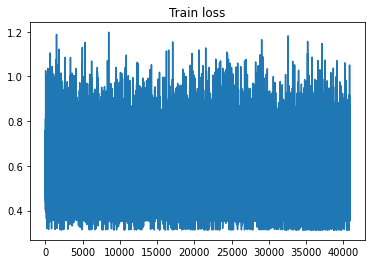

In [43]:
plt.plot(loss_set)
plt.title('Train loss')
plt.show()

In [34]:
my_model.eval()

test_preds, test_labels, test_probs = [], [], []

for batch in tqdm(validation_dataloader):
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    pred_labels = my_model.forward(b_input_ids, b_input_mask)

  b_labels = b_labels.to('cpu').numpy()
  pred_labels = pred_labels.to('cpu').numpy()

  test_probs.extend(pred_labels)
  pred_labels = pred_labels.argmax(axis=1)
  
  test_labels.extend(b_labels)
  test_preds.extend(pred_labels)

100%|██████████| 219/219 [00:29<00:00,  7.34it/s]


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score

test_probs = [list(probs) for probs in test_probs]
test_probs_f = np.array(test_probs)[:, 1]

print(classification_report(test_labels, test_preds))
print('roc_auc ', round(roc_auc_score(test_labels, test_probs_f), 2))
print('f1 ', round(f1_score(test_labels, test_preds), 2))